# Building data Notebook

1. xyz to zip or to location method. (Neareast Neighbors approach)

2. sematics Extraction Notebook

Building Material / Class Extraction - Used for building semantics prediction case.

# 1. ZIP assignment to xyz location

If another type of location then zip would be of interest, the line:

`buiding_locations_df         = buildings_df[["location", "addr:postcode"]]`

should be changed to compute the location id based on a different method, e.g. street intersections, house numbers, etc.

In [1]:
import pandas as pd

#1. buildings data (w/ zip)
buildings_df = pd.read_json("../utils/assets/data/buildingsData_zip_buildingsIndex_11222024.json")
buildings_df["location"]     = buildings_df["World Location"].apply(lambda l: [l["x"],l["y"],l["z"]])
#keep only the location and the zips in buiding_locations_df
buiding_locations_df         = buildings_df[["location", "addr:postcode"]]
buiding_locations_df.columns = ["location", "zip"]
print("Total number of of found Buildings:", buiding_locations_df.shape[0])
#exclude the buildings with no associated zip code:
buiding_locations_df = buiding_locations_df.dropna()
print("Buildings with zip:", buiding_locations_df.shape[0])


#2. xyz locations data (w/o zips) 
test_locations_path = "../utils/assets/data/semantics_final/test_set_as_query.json"
test_df = pd.read_json(test_locations_path)
#create the same column name in test_df as in buiding_locations_df for xyz location
test_df["location"] = test_df[["x", "y", "z"]].values.tolist()


#Test for actual separate physical location - 
print("Total locations: \t", test_df["location"].astype(str).shape
      , "\nUnique locations: \t" , test_df["location"].astype(str).unique().shape)#.groupby("location"))

Total number of of found Buildings: 10439
Buildings with zip: 8445
Total locations: 	 (15000,) 
Unique locations: 	 (2500,)


Train and apply K-NN to assign zip codes to the `test_df` locations

In [2]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Create a KNeighborsClassifier object
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the model to the training data
knn.fit(np.vstack(buiding_locations_df["location"].values), buiding_locations_df["zip"])

# Predict the labels for the testing data
y_pred = knn.predict(np.vstack(test_df["location"].values))

test_df["zip"] = y_pred.astype(int)

test_df[["location", "zip"]]

test_df.drop("location", axis=1).to_json(test_locations_path, indent=4, orient="records")

print(f"Zip location ids saved in place of the original test set at: \n\t{test_locations_path}")

Zip location ids saved in place of the original test set at: 
	../utils/assets/data/semantics_final/test_set_as_query.json


Method for xyz to zip location on server side.

In [3]:
import joblib

knn_path = test_locations_path[:test_locations_path.index("data/")] + "data/zipcode_knn.pkl"


# save
joblib.dump(knn, knn_path) 

print(f"zip code knn model saved at:\n\t{knn_path}")


# load
# knn_loaded_test = joblib.load(knn_path)
# knn_loaded_test.predict(np.vstack(test_df["location"].values))

#Moved to gradient_walk_utils.py on Monday 11.25.2024
def locations_to_zip(xyz_locations):
    '''
    Applies zip code to given xyz locations:
    xyz_locations: (n,3) numpy array of xyz locations
    
    returns zip_codes - np list of ints with zip codes for each location
    '''
    
    path_to_knn = "../utils/assets/data/zipcode_knn.pkl" # Change path when using it in server.py
    knn_loaded_test = joblib.load(path_to_knn)

    zip_codes = knn_loaded_test.predict(xyz_locations).astype(int)

    return zip_codes


locations_to_zip(np.vstack(test_df["location"].values))

zip code knn model saved at:
	../utils/assets/data/zipcode_knn.pkl


array([10029, 10029, 10029, ..., 10024, 10024, 10024])

# 2. Building Material / Class Extraction - Used for building semantics prediction case.

First part is finding which attroibutes in the dataset are not mostly none.

Found that the important / salient categories from the dataset were 

`selected_categories = ['geopipe:window_type', 'building:material', "roof:material", "building", "addr:postcode"]`

selected below.

In [1]:
import pandas as pd
# buildings_df = pd.read_json("./buildingData_full.json")
# buildings_df = pd.read_json("./buildingData_locations_v2.json")
# buildings_df = pd.read_json("./buildingData_final.json")
buildings_df = pd.read_json("../utils/assets/data/buildingsData_zip_buildingsIndex_11222024.json")

# print("\n".join(buildings_df.columns))

buildings_df.head()

,addr:street,roof:height,geopipe:window_type,building:color,ground_elevation,min_height,geopipe:window_props,addr:housenumber,roof:shape,level_height,...,rooms,stars,diet:vegetarian,diet:vegan,dish,atm,clothes:women,service:vehicle:inspection,name:hu,bathroom
0,East 100th Street,0,DoubleHung,0xb81eccff,3.240216,0.0,,410,flat,4.114286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,East 100th Street,0,DoubleHung,0xb81eccff,3.240216,0.0,,410,flat,4.114286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,East 100th Street,0,DoubleHung,0xb81eccff,3.240216,0.0,,410,flat,4.114286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,East 95th Street,0,DoubleHung,0x990094ff,3.390222,0.0,,320,flat,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,East 95th Street,0,DoubleHung,0x990094ff,3.390222,0.0,,320,flat,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Find columns that are potential categories or continous values

In [13]:
potential_columns = [] #columns that are not NaN in majority
column_groups = {} #actual groups for each column
group_counts = {} #how many values are in each group

category_columns  = [] # columns with categorical values
continous_columns = [] # columns with continous values

for bc in buildings_df.columns[1:]:
    if "ocation" in bc: #bc in ["location"]:
        continue
    #1. Exclude columns with many NaNs and less then 5000 values.
    if (~buildings_df[bc].isna()).sum() > 5000:
        potential_columns.append(bc)
        
        num_groups = buildings_df.groupby(bc).count()#.shape[0]
        
        group_counts[bc]  = num_groups.shape[0]
        
        # 3. Check if column is categorical or continous 
        if group_counts[bc] > 100:
            continous_columns.append(bc)
        if 50 > group_counts[bc] > 1:
            category_columns.append(bc)
            column_groups[bc] = num_groups['geopipe:identifier'].to_dict()
        
    
        
len(potential_columns)

20

# Small address / Zip code analysis / geographical region investigation


In [10]:
buildings_df

,geopipe:identifier,geopipe:window_type,building:color,ground_elevation,height,roof:material,geopipe:window_props,building,min_elevation,max_elevation,...,rooms,stars,diet:vegetarian,diet:vegan,dish,atm,clothes:women,service:vehicle:inspection,name:hu,bathroom
0,nlW9XcwCnbG5H0AY8M4DHA==,DoubleHung,0x3e2a7bff,3.050477,3.696470,metal,,yes,2.673863,6.370333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nlW9XcwCnbG5H0AY8M4DHA==,DoubleHung,0x3e2a7bff,3.050477,3.696470,metal,,yes,2.673863,6.370333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nlW9XcwCnbG5H0AY8M4DHA==,DoubleHung,0x3e2a7bff,3.050477,3.696470,metal,,yes,2.673863,6.370333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MLft6q22dZLg0TdLnJboYQ==,DoubleHung,0xce318eff,3.250926,9.500000,metal,,yes,2.660508,7.738888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MLft6q22dZLg0TdLnJboYQ==,DoubleHung,0xce318eff,3.250926,9.500000,metal,,yes,2.660508,7.738888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10434,JDzjTQIArFFC97RohwgRbA==,Picture,0xd8186dff,12.151738,67.099998,metal,,yes,2.136420,62.718819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10435,JDzjTQIArFFC97RohwgRbA==,Picture,0xd8186dff,12.151738,67.099998,metal,,yes,2.136420,62.718819,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10436,HGlhYvKOUFQTEAeTPEhKwQ==,DoubleHung,0x3e2a7bff,7.929774,14.300000,metal,,yes,6.990236,22.058420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10437,HGlhYvKOUFQTEAeTPEhKwQ==,DoubleHung,0x3e2a7bff,7.929774,14.300000,metal,,yes,6.990236,22.058420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
buildings_df.groupby("addr:street").count().sort_values("height", ascending=False)

,geopipe:identifier,geopipe:window_type,building:color,ground_elevation,height,roof:material,geopipe:window_props,building,min_elevation,max_elevation,...,rooms,stars,diet:vegetarian,diet:vegan,dish,atm,clothes:women,service:vehicle:inspection,name:hu,bathroom
addr:street,,,,,,,,,,,,,,,,,,,,,
East 83rd Street,483,483,483,483,483,483,483,483,483,483,...,0,0,0,0,0,0,0,3,0,0
East 82nd Street,483,483,483,483,483,483,483,483,483,483,...,0,0,0,0,0,0,0,0,3,0
East 81st Street,476,476,476,476,476,476,476,476,476,476,...,0,0,0,0,0,0,0,0,0,0
East 84th Street,411,411,411,411,411,411,411,411,411,411,...,0,0,0,0,0,0,0,0,0,0
East 85th Street,369,369,369,369,369,369,369,369,369,369,...,0,0,0,0,0,0,0,0,0,0
East 87th Street,366,366,366,366,366,366,366,366,366,366,...,0,0,0,0,0,0,0,0,0,0
East 89th Street,345,345,345,345,345,345,345,345,345,345,...,0,0,0,0,0,0,0,0,0,0
2nd Avenue,343,343,343,343,343,343,343,343,343,336,...,0,0,0,0,0,0,0,0,0,0
East 88th Street,339,339,339,339,339,339,339,339,339,339,...,0,0,0,0,0,0,0,0,0,0


In [12]:
buildings_df.groupby("addr:postcode").count().sort_values("height", ascending=False)

,geopipe:identifier,geopipe:window_type,building:color,ground_elevation,height,roof:material,geopipe:window_props,building,min_elevation,max_elevation,...,rooms,stars,diet:vegetarian,diet:vegan,dish,atm,clothes:women,service:vehicle:inspection,name:hu,bathroom
addr:postcode,,,,,,,,,,,,,,,,,,,,,
10128.0,3235,3235,3235,3235,3235,3235,3235,3235,3235,3215,...,0,0,0,0,0,0,0,0,0,0
10028.0,3171,3171,3171,3171,3171,3171,3171,3171,3171,3168,...,0,0,3,3,3,0,3,3,3,0
10075.0,893,893,893,893,893,893,893,893,893,890,...,0,0,0,0,0,3,0,0,0,0
10024.0,795,795,795,795,795,795,795,795,795,795,...,0,0,0,0,0,0,0,0,0,0
10029.0,222,222,222,222,222,222,222,222,222,213,...,0,0,0,0,0,0,0,0,0,0
10021.0,93,93,93,93,93,93,93,93,93,93,...,3,3,0,0,0,0,0,0,0,0
11102.0,21,21,21,21,21,21,21,21,21,21,...,0,0,0,0,0,0,0,0,0,0
10025.0,9,9,9,9,9,9,9,9,9,9,...,0,0,0,0,0,0,0,0,0,0
10019.0,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0


In [4]:
potential_columns

['geopipe:window_type',
 'building:color',
 'ground_elevation',
 'height',
 'roof:material',
 'geopipe:window_props',
 'building',
 'min_elevation',
 'max_elevation',
 'geopipe:floor_thickness',
 'roof:color',
 'building:material',
 'level_height',
 'roof:shape',
 'min_height',
 'roof:height',
 'addr:street',
 'addr:housenumber',
 'addr:postcode',
 'nycdoitt:bin']

# Manually checking 

`group_counts` and `column_groups` to see which could be well balanced building data.

In [15]:
selected_categories = ['geopipe:window_type', 'building:material', "roof:material", "building", "addr:postcode"]

In [4]:
# print("\n".join(buildings_df.columns))

# column_groups

# group_counts, 

# Histograms and information on selected categories:

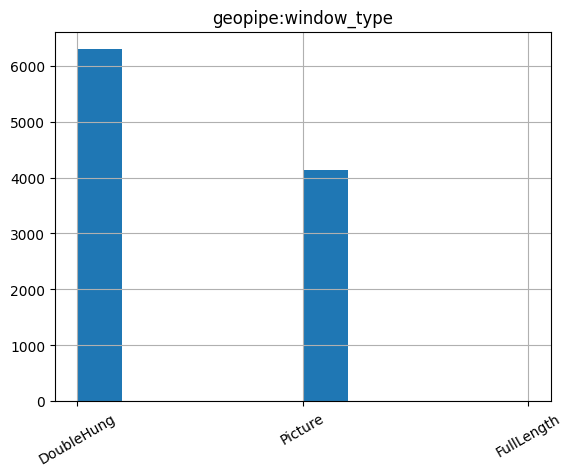

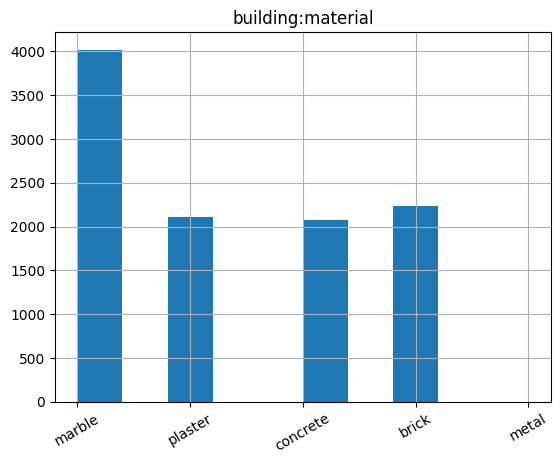

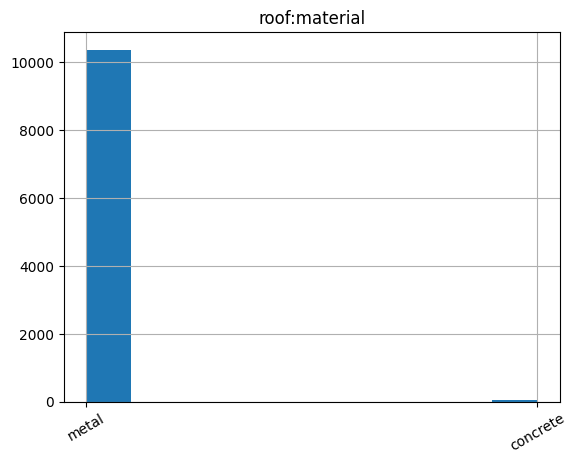

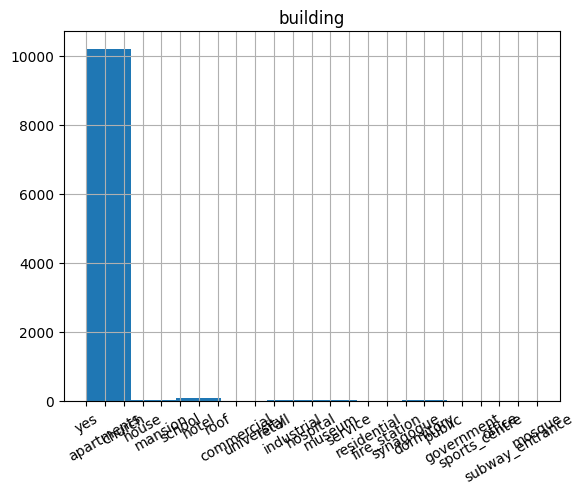

In [20]:
import matplotlib.pyplot as plt

for c in selected_categories:
    
    buildings_df[c].hist()
    plt.title(c)
    plt.xticks(rotation=30)
    plt.show()

In [8]:
categories_df

,geopipe:window_type,building:material,roof:material,building,location
0,DoubleHung,marble,metal,yes,"{'x': 419.6061553955078, 'y': -593.95535278320..."
1,DoubleHung,marble,metal,yes,"{'x': 419.3157958984375, 'y': -593.57427978515..."
2,DoubleHung,marble,metal,yes,"{'x': 419.3157958984375, 'y': -593.57427978515..."
3,DoubleHung,plaster,metal,yes,"{'x': 429.0789031982422, 'y': -643.43093872070..."
4,DoubleHung,plaster,metal,yes,"{'x': 429.05494689941406, 'y': -643.4258117675..."
...,...,...,...,...,...
10434,DoubleHung,marble,metal,yes,"{'x': 451.1592559814453, 'y': -511.60766601562..."
10435,DoubleHung,marble,metal,yes,"{'x': 451.1592559814453, 'y': -511.60766601562..."
10436,DoubleHung,concrete,metal,yes,"{'x': 253.48184204101562, 'y': -359.9487457275..."
10437,DoubleHung,concrete,metal,yes,"{'x': 253.48180389404297, 'y': -359.9487457275..."


# Analysis of continous data

In [4]:
continous_df = buildings_df[continous_columns + ["location"]] 

selected_continous = ['ground_elevation', 'height', "min_elevation"\
                      , "max_elevation", "geopipe:floor_thickness", "level_height"]

continous_df[selected_continous]

continous_df.head()

,building:color,ground_elevation,height,min_elevation,max_elevation,geopipe:floor_thickness,level_height,addr:housenumber,nycdoitt:bin,location
0,0x3e2a7bff,3.050477,3.69647,2.673863,6.370333,0.357928,3.696470,NaN,NaN,"{'x': 0, 'y': 0, 'z': 0}"
1,0x3e2a7bff,3.050477,3.69647,2.673863,6.370333,0.357928,3.696470,NaN,NaN,"{'x': 0, 'y': 0, 'z': 0}"
2,0x3e2a7bff,3.050477,3.69647,2.673863,6.370333,0.357928,3.696470,NaN,NaN,"{'x': 0, 'y': 0, 'z': 0}"
3,0xce318eff,3.250926,9.50000,2.660508,7.738888,0.336768,3.166667,27-02,4005430.0,"{'x': 0, 'y': 0, 'z': 0}"
4,0xce318eff,3.250926,9.50000,2.660508,7.738888,0.336768,3.166667,27-02,4005430.0,"{'x': 0, 'y': 0, 'z': 0}"


<Axes: >

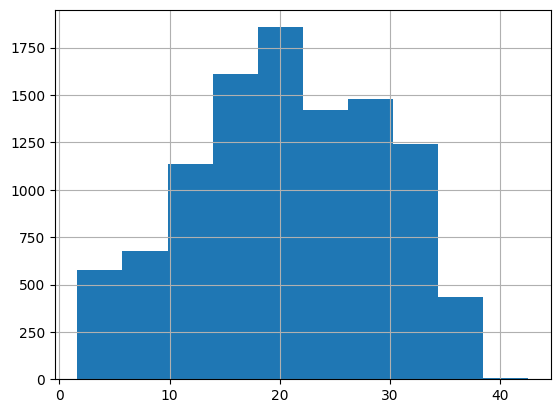

In [23]:
continous_df["ground_elevation"].hist()

In [21]:
(continous_df["ground_elevation"].isna()).sum()

0

In [9]:
continous_df.apply(lambda b: (b["max_elevation"] - b["min_elevation"], b["height"]), axis=1)

0        (3.6964699999999997, 3.69647)
1        (3.6964699999999997, 3.69647)
2        (3.6964699999999997, 3.69647)
3                       (5.07838, 9.5)
4                       (5.07838, 9.5)
                     ...              
10434           (20.512692, 18.200001)
10435           (20.512692, 18.200001)
10436       (18.875342000000003, 18.0)
10437       (18.875342000000003, 18.0)
10438       (18.875342000000003, 18.0)
Length: 10439, dtype: object

In [12]:
continous_df.apply(lambda b: (b["max_elevation"] - b["min_elevation"], b["height"]), axis=1)


# continous_df.apply(lambda b: (b["max_elevation"] - b["min_elevation"] - b["height"]), axis=1)#.hist()

0        (3.6964699999999997, 3.69647)
1        (3.6964699999999997, 3.69647)
2        (3.6964699999999997, 3.69647)
3                       (5.07838, 9.5)
4                       (5.07838, 9.5)
                     ...              
10434           (20.512692, 18.200001)
10435           (20.512692, 18.200001)
10436       (18.875342000000003, 18.0)
10437       (18.875342000000003, 18.0)
10438       (18.875342000000003, 18.0)
Length: 10439, dtype: object

In [ ]:
continous_df.apply()

In [65]:
selected_continous = ['ground_elevation', 'height', "min_elevation"\
                      , "max_elevation", "geopipe:floor_thickness", "level_height"]

buildings_df["level_height"].sort_values(ascending=False).head(15)
buildings_df["level_height"] = buildings_df["level_height"].apply(lambda h: 10 if h >= 10 else h)#.sort_values(ascending=False).head(15)# .iloc[897] == np.inf # = 

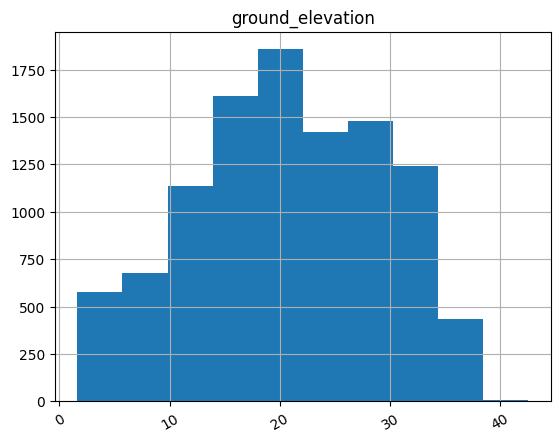

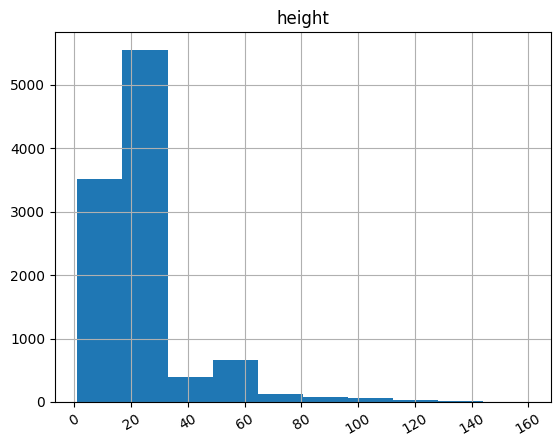

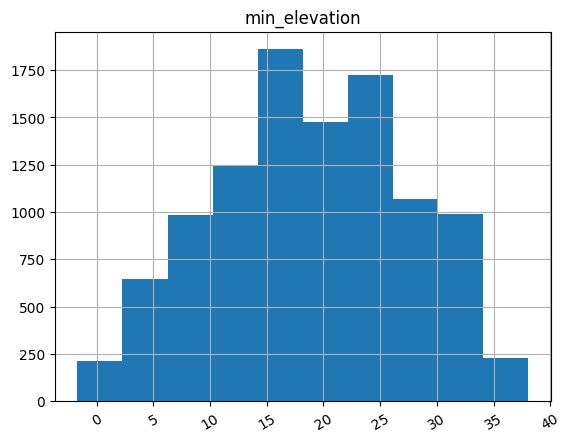

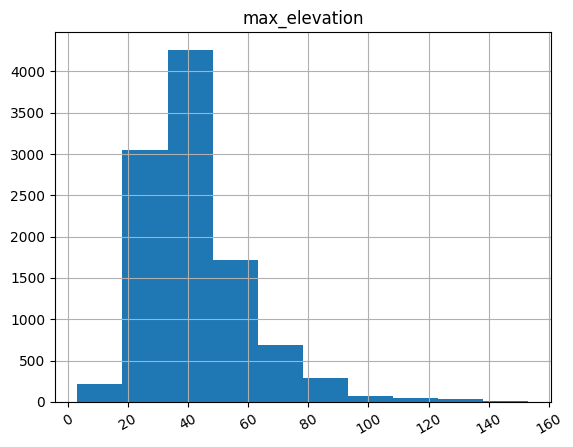

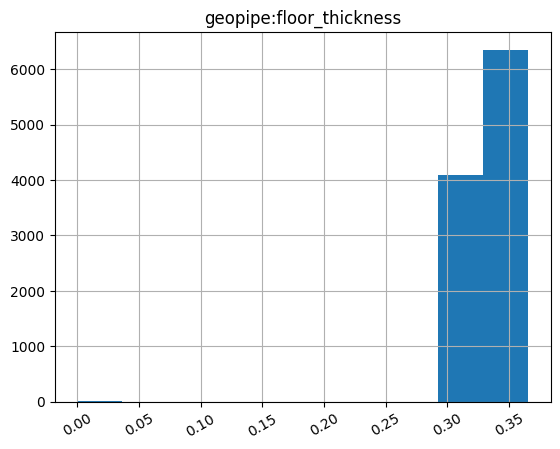

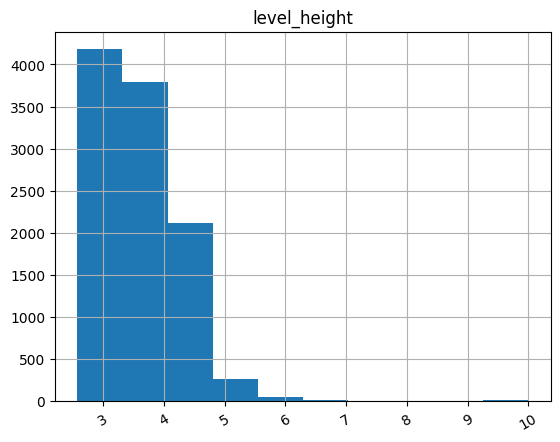

In [66]:
import matplotlib.pyplot as plt

for c in selected_continous:
    
    buildings_df[c].hist()
    plt.title(c)
    plt.xticks(rotation=30)
    plt.show()


# Plot buildings as 3D points

In [7]:
import open3d as o3d
import seaborn as sns

category_color = sns.color_palette(n_colors=30)
# category_color = sns.color_palette("Set2",30)
# category_color = sns.color_palette("husl", 30)
# category_color = sns.color_palette("Paired", 30)

categories_df = buildings_df[selected_categories + ["location"]]

category_color

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [17]:
categories_list

[10019.0,
 10021.0,
 10024.0,
 10025.0,
 10028.0,
 10029.0,
 10044.0,
 10075.0,
 10128.0,
 11102.0]

In [29]:
buildings_df["addr:postcode"].apply(lambda x: categories_list.index(x) if x in categories_list else -1)

0        5
1        5
2        5
3        8
4        8
        ..
10434    4
10435    4
10436    4
10437    4
10438    4
Name: addr:postcode, Length: 10439, dtype: int64

In [31]:
category_color[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [ ]:
import numpy as np

# sel_cat = selected_categories[0]

for sel_cat in selected_categories:
    np_locations = np.vstack(categories_df["location"].apply(lambda d: list(d.values())))

    pcd_categorical = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np_locations))

    #assign color to each building based on category
    categories_list = list(column_groups[sel_cat].keys())
    np_colors       = np.vstack(buildings_df[sel_cat].apply(lambda x: 
                            category_color[categories_list.index(x)] if x in categories_list else (0,0,0)))

    pcd_categorical.colors = o3d.utility.Vector3dVector(np_colors)

    pcd_categorical

    o3d.visualization.draw_geometries([pcd_categorical], window_name=sel_cat)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [8]:
o3d.visualization.draw_geometries([pcd_categorical], window_name=sel_cat)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [45]:
np.vstack(buildings_df[sel_cat].apply(lambda x: category_color[categories_list.index(x)]))

array([[0.4       , 0.76078431, 0.64705882],
       [0.4       , 0.76078431, 0.64705882],
       [0.4       , 0.76078431, 0.64705882],
       ...,
       [0.4       , 0.76078431, 0.64705882],
       [0.4       , 0.76078431, 0.64705882],
       [0.4       , 0.76078431, 0.64705882]])

In [36]:

sns.color_palette("Set2",8)[0]

(0.4, 0.7607843137254902, 0.6470588235294118)

In [39]:
list(column_groups[selected_categories[0]].keys())

['DoubleHung', 'FullLength', 'Picture']

In [34]:
import seaborn as sns

# sns.color_palette()
sns.color_palette("Set2",8)
# sns.color_palette("husl", 6)
# sns.color_palette("hls", 6)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [13]:
categories_df

,geopipe:window_type,building:material,roof:material,building,location
0,DoubleHung,marble,metal,yes,"[2491.73, -2.1868913346878573e-13, 984.8883]"
1,DoubleHung,marble,metal,yes,"[2491.73, -2.1868913346878573e-13, 984.8883]"
2,DoubleHung,marble,metal,yes,"[2491.73, -2.1868913346878573e-13, 984.8883]"
3,DoubleHung,plaster,metal,yes,"[2491.73, -2.1868913346878573e-13, 984.8883]"
4,DoubleHung,plaster,metal,yes,"[2491.73, -2.1868913346878573e-13, 984.8883]"
...,...,...,...,...,...
10434,Picture,brick,metal,yes,"[1007.011, -2.830198297942843e-13, 1274.608]"
10435,Picture,brick,metal,yes,"[1007.011, -2.830198297942843e-13, 1274.608]"
10436,DoubleHung,brick,metal,yes,"[1007.011, -2.830198297942843e-13, 1274.608]"
10437,DoubleHung,brick,metal,yes,"[1007.011, -2.830198297942843e-13, 1274.608]"


In [3]:
category_columns

['geopipe:window_type',
 'roof:material',
 'geopipe:window_props',
 'building',
 'roof:color',
 'building:material',
 'roof:shape',
 'min_height',
 'roof:height',
 'addr:street',
 'addr:postcode']

In [63]:
continous_columns, category_columns

(['building:color',
  'ground_elevation',
  'height',
  'min_elevation',
  'max_elevation',
  'geopipe:floor_thickness',
  'level_height',
  'addr:housenumber',
  'nycdoitt:bin'],
 ['geopipe:window_type',
  'roof:material',
  'geopipe:window_props',
  'building',
  'roof:color',
  'building:material',
  'roof:shape',
  'min_height',
  'roof:height',
  'addr:street',
  'addr:postcode'])

In [45]:
num_groups

,geopipe:identifier,geopipe:window_type,building:color,ground_elevation,height,roof:material,geopipe:window_props,building,min_elevation,max_elevation,...,tourism_1,rooms,stars,diet:vegetarian,diet:vegan,dish,atm,clothes:women,service:vehicle:inspection,name:hu
nycdoitt:bin,,,,,,,,,,,,,,,,,,,,,
1000000.0,16,16,16,16,16,16,16,16,16,16,...,0,0,0,0,0,0,0,0,0,0
1031232.0,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
1031233.0,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
1031307.0,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
1031308.0,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430789.0,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
4430790.0,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
4430791.0,3,3,3,3,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0


In [46]:
column_groups

{'geopipe:window_type': geopipe:window_type
 DoubleHung    6297
 FullLength      11
 Picture       4131
 Name: geopipe:identifier, dtype: int64,
 'building:color': building:color
 0x0094a0ff     3
 0x015f19ff     9
 0x02a44cff     3
 0x03d231ff     9
 0x04a9b9ff    45
               ..
 0xdf4f0fff     6
 0xe0bab9ff    12
 0xe0d8e1ff    15
 0xe16511ff    39
 0xe1dadaff    84
 Name: geopipe:identifier, Length: 282, dtype: int64,
 'ground_elevation': ground_elevation
 1.623756     2
 2.377956     3
 2.491196     3
 2.567740     3
 2.643434     3
             ..
 36.976475    3
 37.107895    3
 37.158825    3
 37.262562    3
 42.539108    6
 Name: geopipe:identifier, Length: 3391, dtype: int64,
 'height': height
 1.061697      2
 1.176372      2
 1.270847      2
 2.200000      2
 2.494858      2
              ..
 136.800003    3
 141.699997    3
 142.300003    3
 150.000000    3
 160.000000    3
 Name: geopipe:identifier, Length: 606, dtype: int64,
 'roof:material': roof:material
 concrete

In [33]:
buildings_df.groupby("roof:height").count().shape[0]

1

In [28]:
(buildings_df["roof:height"] != 0).sum()

0

In [25]:
buildings_df[potential_columns]

,geopipe:identifier,geopipe:window_type,building:color,ground_elevation,height,roof:material,geopipe:window_props,building,min_elevation,max_elevation,...,roof:color,building:material,level_height,roof:shape,min_height,roof:height,addr:street,addr:housenumber,addr:postcode,nycdoitt:bin
0,nlW9XcwCnbG5H0AY8M4DHA==,DoubleHung,0x3e2a7bff,3.050477,3.696470,metal,,yes,2.673863,6.370333,...,0x000000ff,marble,3.696470,flat,0.0,0,NaN,NaN,NaN,NaN
1,nlW9XcwCnbG5H0AY8M4DHA==,DoubleHung,0x3e2a7bff,3.050477,3.696470,metal,,yes,2.673863,6.370333,...,0x000000ff,marble,3.696470,flat,0.0,0,NaN,NaN,NaN,NaN
2,nlW9XcwCnbG5H0AY8M4DHA==,DoubleHung,0x3e2a7bff,3.050477,3.696470,metal,,yes,2.673863,6.370333,...,0x000000ff,marble,3.696470,flat,0.0,0,NaN,NaN,NaN,NaN
3,MLft6q22dZLg0TdLnJboYQ==,DoubleHung,0xce318eff,3.250926,9.500000,metal,,yes,2.660508,7.738888,...,0x000000ff,plaster,3.166667,flat,0.0,0,1st Street,27-02,11102.0,4005430.0
4,MLft6q22dZLg0TdLnJboYQ==,DoubleHung,0xce318eff,3.250926,9.500000,metal,,yes,2.660508,7.738888,...,0x000000ff,plaster,3.166667,flat,0.0,0,1st Street,27-02,11102.0,4005430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10434,IAZWY062n6Y8tGVtcpEynA==,DoubleHung,0x4fcd2cff,12.952456,18.200001,metal,,yes,10.747659,31.260351,...,0x000000ff,marble,4.550000,flat,0.0,0,East 82nd Street,505,10028.0,1051156.0
10435,IAZWY062n6Y8tGVtcpEynA==,DoubleHung,0x4fcd2cff,12.952456,18.200001,metal,,yes,10.747659,31.260351,...,0x000000ff,marble,4.550000,flat,0.0,0,East 82nd Street,505,10028.0,1051156.0
10436,iBdaRW7z8Wr7oy7/sK6hhg==,DoubleHung,0x7b3e2aff,16.115240,18.000000,metal,,yes,14.475938,33.351280,...,0x000000ff,concrete,3.600000,flat,0.0,0,1st Avenue,1590,10028.0,1050444.0
10437,iBdaRW7z8Wr7oy7/sK6hhg==,DoubleHung,0x7b3e2aff,16.115240,18.000000,metal,,yes,14.475938,33.351280,...,0x000000ff,concrete,3.600000,flat,0.0,0,1st Avenue,1590,10028.0,1050444.0


In [23]:
potential_columns

['geopipe:identifier',
 'geopipe:window_type',
 'building:color',
 'ground_elevation',
 'height',
 'roof:material',
 'geopipe:window_props',
 'building',
 'min_elevation',
 'max_elevation',
 'geopipe:floor_thickness',
 'roof:color',
 'building:material',
 'level_height',
 'roof:shape',
 'min_height',
 'roof:height',
 'addr:street',
 'addr:housenumber',
 'addr:postcode',
 'nycdoitt:bin']

In [14]:
(~buildings_df["rooms"].isna()).sum()

3

geopipe:identifier
geopipe:window_type
building:color
ground_elevation
height
roof:material
geopipe:window_props
building
min_elevation
max_elevation
geopipe:floor_thickness
roof:color
building:material
level_height
roof:shape
min_height
roof:height
addr:street
addr:housenumber
addr:postcode
nycdoitt:bin
wikidata
heritage:operator
seamark:type
ref:nrhp
heritage
wikipedia
historic
man_made
name
amenity
addr:state
addr:city
image
start_date
denomination
ele
gnis:feature_id
religion
website
branch
phone
old_name
fee
architect:wikidata
email
architect
isced:level
fax
architect:wikipedia
building:levels:underground
min_age
type
lpc:inscription_date
building:architecture
owner
ref:lpc
heritage:website
building:wikidata
country
building:wikipedia
source
gnis:import_uuid
office
gnis:reviewed
diplomatic
name:ru
building:name
target
consulate
gnis:county_name
opening_hours
delivery
shop
wheelchair
building:use
max_level
gnis:created
gnis:county_id
gnis:state_id
name:uk
operator
alt_name
tourism
